In [ ]:
#Importing necessary libraries
import re
import spacy
!python -m spacy download en_core_web_sm
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2023-12-01 19:06:54.203221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Load Dataset from DBFS

In [ ]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/vlimbhar@gmu.edu/Airline_Sentiment_dataset.csv")

In [ ]:
display(df1)

_unit_id _golden _unit_state _trusted_judgments _last_judgment_at airline_sentiment airline_sentiment:confidence negativereason negativereason:confidence airline airline_sentiment_gold name negativereason_gold retweet_count text tweet_coord tweet_created tweet_id tweet_location user_timezone 681448150 FALSE finalized 3 2/25/15 5:24 neutral 1 null null Virgin America null cairdin null 0 @VirginAmerica What @dhepburn said. null 2/24/15 11:35 5.70306E+17 null Eastern Time (US & Canada) 681448153 FALSE finalized 3 2/25/15 1:53 positive 0.3486 null 0 Virgin America null jnardino null 0 @VirginAmerica plus you've added commercials to the experience... tacky. null 2/24/15 11:15 5.70301E+17 null Pacific Time (US & Canada) 681448156 FALSE finalized 3 2/25/15 10:01 neutral 0.6837 null null Virgin America null yvonnalynn null 0 @VirginAmerica I didn't today... Must mean I need to take another trip! null 2/24/15 11:15 5.70301E+17 Lets Play Central Time (US & Canada) 681448158 FALSE finalized 3 2/25/15 3:05 negative 1 Bad Flight 0.7033 Virgin America null jnardino null 0 "@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse" null 2/24/15 11:15 5.70301E+17 null Pacific Time (US & Canada) 681448159 FALSE finalized 3 2/25/15 5:50 negative 1 Can't Tell 1 Virgin America null jnardino null 0 @VirginAmerica and it's a really big bad thing about it null 2/24/15 11:14 5.70301E+17 null Pacific Time (US & Canada) 681448162 FALSE finalized 3 2/25/15 9:10 negative 1 Can't Tell 0.6842 Virgin America null jnardino null 0 @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
 null null null null null it's really the only bad thing about flying VA" null 2/24/15 11:14 5.70301E+17 null Pacific Time (US & Canada) null null null null null null null null null null null null null null 681448165 FALSE finalized 3 2/25/15 8:11 positive 0.6745 null 0 Virgin America null cjmcginnis null 0 @VirginAmerica yes, nearly every time I fly VX this ���ear worm�۝ won�۪t go away :) null 2/24/15 11:13 5.70301E+17 San Francisco CA Pacific Time (US & Canada) 681448167 FALSE finalized 3 2/25/15 2:11 neutral 0.634 null null Virgin America null pilot null 0 @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP null 2/24/15 11:12 5.703E+17 Los Angeles Pacific Time (US & Canada) 681448169 FALSE finalized 3 2/25/15 9:01 positive 0.6559 null null Virgin America null dhepburn null 0 @virginamerica Well, I didn't��_but NOW I DO! :-D null 2/24/15 11:11 5.703E+17 San Diego Pacific Time (US & Canada) 681448171 FALSE finalized 3 2/25/15 4:15 positive 1 null null Virgin America null YupitsTate null 0 @VirginAmerica it was amazing, and arrived an hour early. You're too good to me. null 2/24/15 10:53 5.70295E+17 Los Angeles Eastern Time (US & Canada) 681448174 FALSE finalized 3 2/25/15 8:34 neutral 0.6769 null 0 Virgin America null idk_but_youtube null 0 @VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24 null 2/24/15 10:48 5.70294E+17 1/1 loner squad Eastern Time (US & Canada) 681448176 FALSE finalized 3 2/25/15 2:03 positive 1 null null Virgin America null HyperCamiLax null 0 @VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D null 2/24/15 10:30 5.7029E+17 NYC America/New_York 681448178 FALSE finalized 3 2/25/15 2:13 positive 1 null null Virgin America null HyperCamiLax null 0 @VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia & I haven't even gone on my 1st trip yet! ;p null 2/24/15 10:30 5.7029E+17 NYC America/New_York 681448181 FALSE finalized 3 2/25/15 5:39 positive 0.6451 null null Virgin America null mollanderson null 0 @VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn null 2/24/15 10:21 5.70287E+17 null Eastern Time (US & Canad

In [ ]:
data = df1.select('text','airline_sentiment')
data.show(truncate = False,n=5)

+----------------------------------------------------------------------------------------------------------------------------------+-----------------+
|text                                                                                                                              |airline_sentiment|
+----------------------------------------------------------------------------------------------------------------------------------+-----------------+
|@VirginAmerica What @dhepburn said.                                                                                               |neutral          |
|@VirginAmerica plus you've added commercials to the experience... tacky.                                                          |positive         |
|@VirginAmerica I didn't today... Must mean I need to take another trip!                                                           |neutral          |
|"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' f

Data Cleaning & Manipulation

In [ ]:
# Map sentiment labels to integers
data = data.withColumn("airline_sentiment_num", when(col("airline_sentiment") == "negative", 0)
                           .when(col("airline_sentiment") == "neutral", 1)
                           .when(col("airline_sentiment") == "positive", 2)
                           .otherwise(None))

# Select required columns
result_df = data.select("text", "airline_sentiment_num")

# Show the results
result_df.show(truncate = False,n=5)

+----------------------------------------------------------------------------------------------------------------------------------+---------------------+
|text                                                                                                                              |airline_sentiment_num|
+----------------------------------------------------------------------------------------------------------------------------------+---------------------+
|@VirginAmerica What @dhepburn said.                                                                                               |1                    |
|@VirginAmerica plus you've added commercials to the experience... tacky.                                                          |2                    |
|@VirginAmerica I didn't today... Must mean I need to take another trip!                                                           |1                    |
|"@VirginAmerica it's really aggressive to blast obnoxious ""entertain

In [ ]:
result_df = result_df.na.drop(subset=["text"]) #remove rows containing null values

In [ ]:
def clean_text(text):
    # Remove words starting from '@'
    text = re.sub(r'@\w*', '', text)
    # Replace special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove html tags
    text = re.sub(r'http.*', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [ ]:
# Define the UDF
clean_text_udf = udf(clean_text, StringType())

# Apply the cleaning UDF to the "text" column
cleaned_data = result_df.withColumn("cleaned_text", clean_text_udf(col("text")))

In [ ]:
# Replace the "text" column with the cleaned text
cleaned_data = cleaned_data.drop("text").withColumnRenamed("cleaned_text", "text")

In [ ]:
cleaned_data.show(truncate=False, n=5)

+---------------------+--------------------------------------------------------------------------------------------------------------------+
|airline_sentiment_num|text                                                                                                                |
+---------------------+--------------------------------------------------------------------------------------------------------------------+
|1                    | what  said                                                                                                         |
|2                    | plus you ve added commercials to the experience    tacky                                                           |
|1                    | i didn t today    must mean i need to take another trip                                                            |
|0                    |  it s really aggressive to blast obnoxious   entertainment   in your guests  faces  amp  they have little recourse |
|0           

In [ ]:
cleaned_data = cleaned_data.na.drop(subset=["text"]) #remove rows containing null values

In [ ]:
#divide data into 70-30 split for training and testing set respectively
randomsplit = cleaned_data.randomSplit([0.7, 0.3])
train_data = randomsplit[0] #70% training data
test_data = randomsplit[1] #30% test data
train_rows = train_data.count()
test_rows = test_data.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 10159 ; Testing data rows: 4473


In [ ]:
test_data.show(truncate=False, n=50)

+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|airline_sentiment_num|text                                                                                                                                        |
+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|0                    |                                                                                                                                            |
|0                    |                                                                                                                                            |
|0                    |                                                                                                                                            |
|0        

1.Preprocessing Training Data using Tokenizer, HashingTF and Stopword removal

1.1 Tokenization

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="Tokens")

In [ ]:
tokenizedTrain = tokenizer.transform(train_data)
tokenizedTrain.show(truncate=False, n=5)

+---------------------+----+------+
|airline_sentiment_num|text|Tokens|
+---------------------+----+------+
|0                    |    |[]    |
|0                    |    |[]    |
|0                    |    |[]    |
|0                    |    |[]    |
|0                    |    |[]    |
+---------------------+----+------+
only showing top 5 rows



1.2 Stop Word Removal

In [ ]:
swr = StopWordsRemover(inputCol= tokenizer.getOutputCol(), outputCol="Meaningful_Tokens")

In [ ]:
swrTrain = swr.transform(tokenizedTrain)
swrTrain.show(truncate=False, n=5)

+---------------------+----+------+-----------------+
|airline_sentiment_num|text|Tokens|Meaningful_Tokens|
+---------------------+----+------+-----------------+
|0                    |    |[]    |[]               |
|0                    |    |[]    |[]               |
|0                    |    |[]    |[]               |
|0                    |    |[]    |[]               |
|0                    |    |[]    |[]               |
+---------------------+----+------+-----------------+
only showing top 5 rows



1.3 Hashing using HashingTF function

In [ ]:
hashTF = HashingTF(inputCol= swr.getOutputCol(), outputCol="Hashed_Tokens")

In [ ]:
hashedTrain = hashTF.transform(swrTrain).select('airline_sentiment_num', 'Meaningful_Tokens', 'Hashed_Tokens')
hashedTrain.show(truncate= False, n=5)

+---------------------+-----------------+--------------+
|airline_sentiment_num|Meaningful_Tokens|Hashed_Tokens |
+---------------------+-----------------+--------------+
|0                    |[]               |(262144,[],[])|
|0                    |[]               |(262144,[],[])|
|0                    |[]               |(262144,[],[])|
|0                    |[]               |(262144,[],[])|
|0                    |[]               |(262144,[],[])|
+---------------------+-----------------+--------------+
only showing top 5 rows



1.4 Inverse Document Frequency(IDF)

In [ ]:
idf = IDF(inputCol= hashTF.getOutputCol(), outputCol="InverseDocFreq")

In [ ]:
idfModel = idf.fit(hashedTrain)
tfidfTrain = idfModel.transform(hashedTrain)

2. Logistic Regression Model on Training set

In [ ]:
lr = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol="airline_sentiment_num", family="multinomial")

In [ ]:
model = lr.fit(tfidfTrain)
print("Job Completed!")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Job Completed!


3. Prediction on Test data

In [ ]:
test_data.show(truncate=False, n=3)

+---------------------+----+
|airline_sentiment_num|text|
+---------------------+----+
|0                    |    |
|0                    |    |
|0                    |    |
+---------------------+----+
only showing top 3 rows



In [ ]:
tokenizedTest = tokenizer.transform(test_data)
swrTest = swr.transform(tokenizedTest)
hashTest = hashTF.transform(swrTest).select('airline_sentiment_num', 'Meaningful_Tokens', 'Hashed_Tokens')
tfidfTest = idfModel.transform(hashTest)

In [ ]:
tfidfTest.show(truncate=False, n=3)

+---------------------+-----------------+--------------+--------------+
|airline_sentiment_num|Meaningful_Tokens|Hashed_Tokens |InverseDocFreq|
+---------------------+-----------------+--------------+--------------+
|0                    |[]               |(262144,[],[])|(262144,[],[])|
|0                    |[]               |(262144,[],[])|(262144,[],[])|
|0                    |[]               |(262144,[],[])|(262144,[],[])|
+---------------------+-----------------+--------------+--------------+
only showing top 3 rows



In [ ]:
prediction = model.transform(tfidfTest)

In [ ]:
predictionFinal = prediction.select(
    "Meaningful_Tokens", "prediction", "airline_sentiment_num")
predictionFinal.show(n=4, truncate = False)
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['airline_sentiment_num']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+-----------------+----------+---------------------+
|Meaningful_Tokens|prediction|airline_sentiment_num|
+-----------------+----------+---------------------+
|[]               |1.0       |0                    |
|[]               |1.0       |0                    |
|[]               |1.0       |0                    |
|[]               |1.0       |0                    |
+-----------------+----------+---------------------+
only showing top 4 rows

correct prediction: 2933 , total data: 4473 , accuracy: 0.6557120500782473


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="airline_sentiment_num", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)

In [ ]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.6557120500782473


In [ ]:
# Evaluating the model
evaluator = MulticlassClassificationEvaluator(labelCol="airline_sentiment_num", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)

# Precision, Recall, and F1 Score
evaluator = MulticlassClassificationEvaluator(labelCol="airline_sentiment_num", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(prediction)

evaluator = MulticlassClassificationEvaluator(labelCol="airline_sentiment_num", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(prediction)

evaluator = MulticlassClassificationEvaluator(labelCol="airline_sentiment_num", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(prediction)

#Evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6557120500782473
Precision: 0.6793210495963714
Recall: 0.6557120500782474
F1 Score: 0.6648925333701172


In [ ]:
prediction_and_label = prediction.select("prediction", "airline_sentiment_num").rdd.map(lambda row: (float(row["prediction"]), float(row["airline_sentiment_num"])))


In [ ]:
# Create a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Confusion matrix
confusion_matrix = metrics.confusionMatrix()

#Print Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

/databricks/spark/python/pyspark/sql/context.py:166: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[2042.,  505.,  252.],
             [ 312.,  470.,  168.],
             [ 154.,  149.,  421.]])


In [ ]:
confusion_matrix = metrics.confusionMatrix().toArray()
# Converting to integers to avoid the "ValueError"
confusion_matrix = confusion_matrix.astype(int)

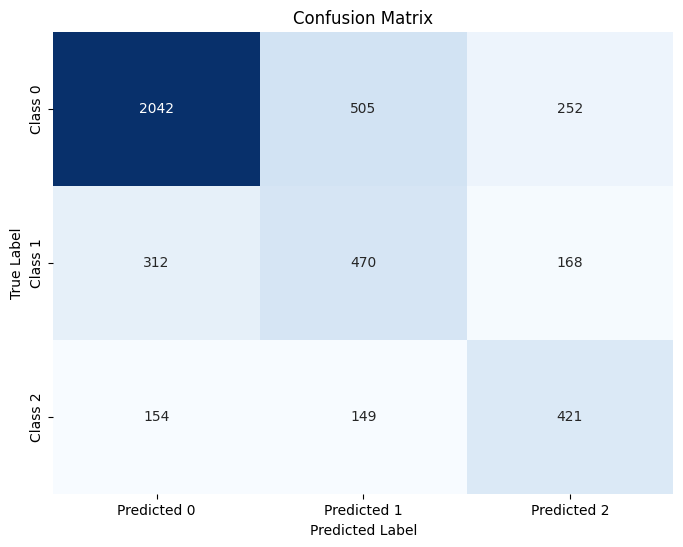

In [ ]:
confusion_df = pd.DataFrame(confusion_matrix, index=["Class 0", "Class 1", "Class 2"], columns=["Predicted 0", "Predicted 1", "Predicted 2"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(featuresCol=idf.getOutputCol(), labelCol="airline_sentiment_num", numTrees=10)
rf_model = rf.fit(tfidfTrain)
print("Random Forest Job Completed!")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Random Forest Job Completed!
+---------------------+-----------------+--------------+--------------+
|airline_sentiment_num|Meaningful_Tokens|Hashed_Tokens |InverseDocFreq|
+---------------------+-----------------+--------------+--------------+
|0                    |[]               |(262144,[],[])|(262144,[],[])|
|0                    |[]               |(262144,[],[])|(262144,[],[])|
|0                    |[]               |(262144,[],[])|(262144,[],[])|
+---------------------+-----------------+--------------+--------------+
only showing top 3 rows

+-----------------+----------+---------------------+
|Meaningful_Tokens|prediction|airline_sentiment_num|
+-----------------+----------+---------------------+
|[]               |0.0       |0                    |
|[]               |0.0       |0                    |
|[]               |0.0       |0                    |
|[]               |0.0       |0                    |
+-----------------+----------+---------------------+
only showing top 4

In [ ]:

# Prediction on Test Data
tfidfTest.show(truncate=False, n=3)

prediction_rf = rf_model.transform(tfidfTest)

prediction_final_rf = prediction_rf.select(
    "Meaningful_Tokens", "prediction", "airline_sentiment_num")
prediction_final_rf.show(n=4, truncate=False)

# Evaluate the Random Forest Model
evaluator_rf = MulticlassClassificationEvaluator(labelCol="airline_sentiment_num", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(prediction_rf)

# Precision, Recall, and F1 Score for Random Forest
precision_rf = evaluator_rf.evaluate(prediction_rf, {evaluator_rf.metricName: "weightedPrecision"})
recall_rf = evaluator_rf.evaluate(prediction_rf, {evaluator_rf.metricName: "weightedRecall"})
f1_rf = evaluator_rf.evaluate(prediction_rf, {evaluator_rf.metricName: "f1"})

#Evaluation metrics for Random Forest
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")